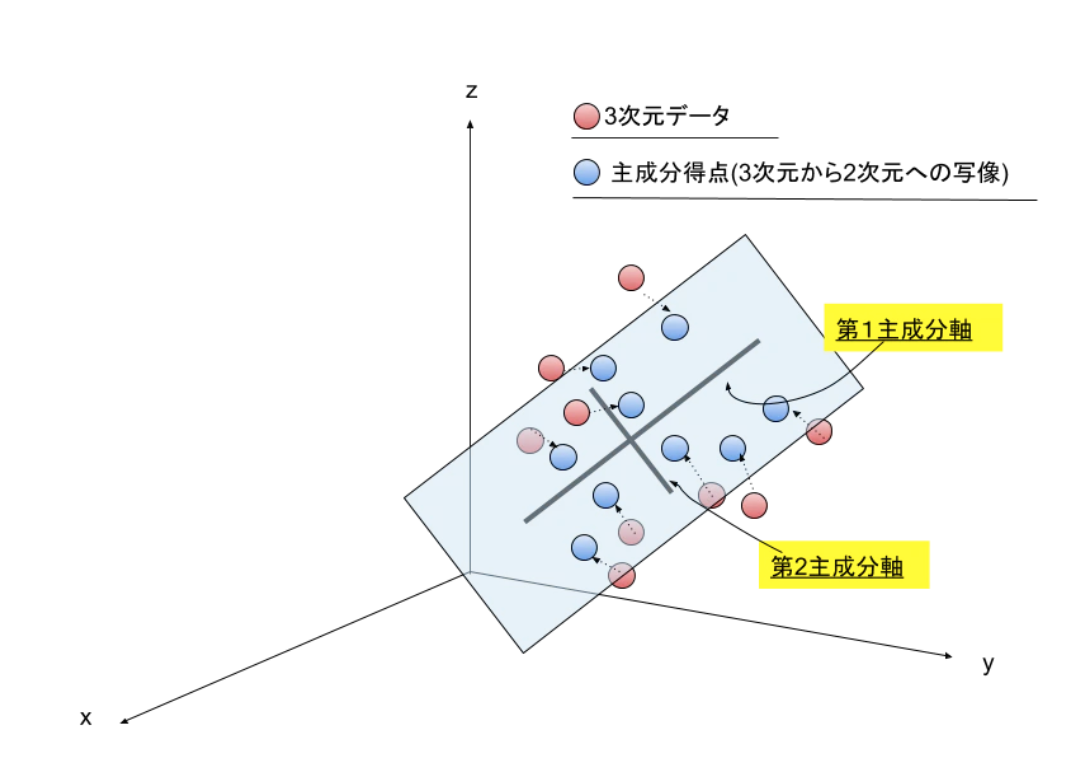

共分散行列の作成手順

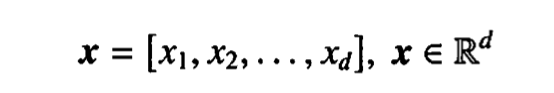
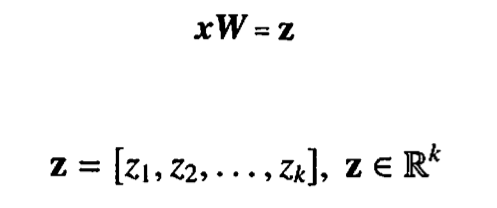


In [1]:
import pandas as pd
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/'
                   'machine-learning-databases/wine/wine.data',  header=None)

In [2]:
#wineデータセットを処理して訓練データセット(データの7割)とテストデータに分割し，分散が１となるように標準化する
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#２列目以降のデータをxに，１列目のデータをyに格納
x,y=df_wine.iloc[:, 1:].values,  df_wine.iloc[:,0].values

#訓練データとテストデータに分割
x_train, x_test, y_train,  y_test=train_test_split(
                                              x,y,test_size=0.3, stratify=y, random_state=0)

#平均と標準偏差を用いて標準化
sc=StandardScaler()
x_train_std=sc.fit_transform(x_train)
x_test_std=sc.transform(x_test)

                                                        
                                                        
                                                        
                       2つの特徴量xjとxkの間の共分散は次の式で計算可能
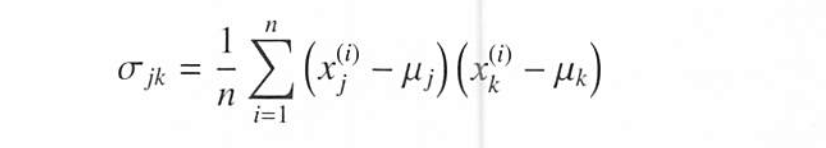


                        3つの特徴量からなる共分散行列は次のように記述可能
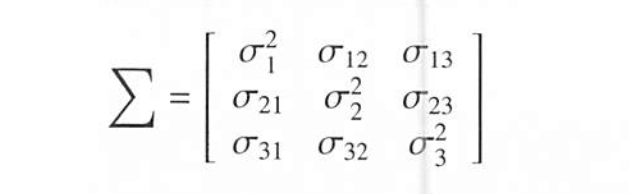

固有ベクトルvは次の条件を満たす
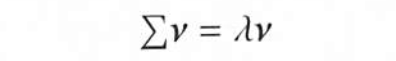

In [20]:
import numpy as np  
cov_mat=np.cov(x_train_std.T)    #共分散行列を作成
eigen_vals,  eigen_vecs=np.linalg.eig(cov_mat)  #固有値と固有ベクトルを計算
print('\nEigenvalues. \n%s'  % eigen_vals)  #13x13次元の行列の列として格納された対応する固有ベクトルを生成



Eigenvalues. 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


分散説明率の累積和
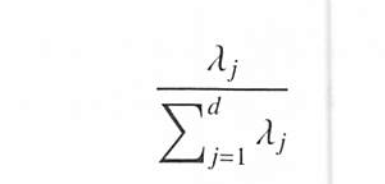

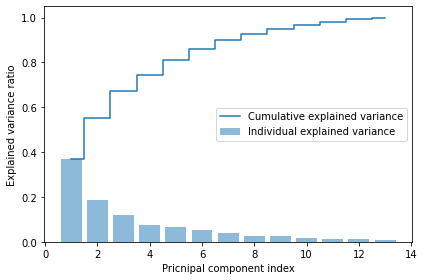

In [21]:
#固有値を合計
tot=sum(eigen_vals)

#分散説明率を計算
var_exp=[(i  / tot) for i in sorted(eigen_vals,  reverse=True)]

#分散説明率の累積和を取得
cum_var_exp=np.cumsum(var_exp)
import matplotlib.pyplot as plt

#分散説明率の棒グラフを計算
plt.bar(range(1,14), var_exp,alpha=0.5, align='center',
       label='Individual explained variance')

#分散説明率の累積和の階段グラフを作成
plt.step(range(1,14),cum_var_exp, where='mid',
        label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Pricnipal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#ランダムフォレストはデータの所属情報を使ってノードの不純度を計算する
#PCAで計算される分散は特徴量軸に沿った値の散らばりを計測する

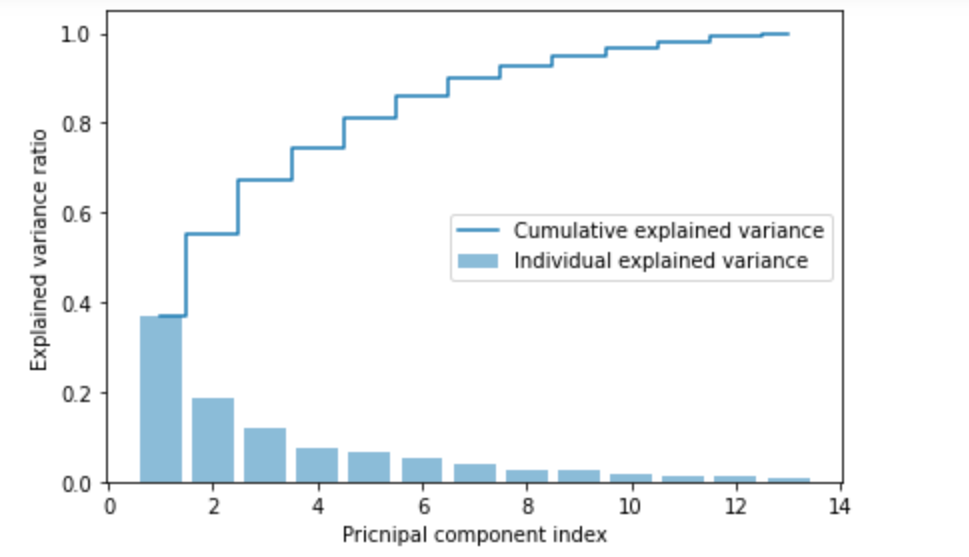

In [22]:
#(固有値，固有ベクトル)のタプルのリストを作成
eigen_pairs=[(np.abs(eigen_vals[i]),eigen_vecs[:,i])
            for i in range(len(eigen_vals))]

#(固有値,固有ベクトル)のタプルを大きいものから順に並び替え
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

#固有値の大きいものから順に固有対を並び替える

In [23]:
#最も大きい二つの固有値に対応する二つの固有ベクトルを集める   上位二つの固有ベクトルから13X2次元の射影行列Wが作成される
w=np.hstack((eigen_pairs[0][1][:, np.newaxis],  eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n',w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [24]:
x_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [25]:
x_train_pca=x_train_std.dot(w)

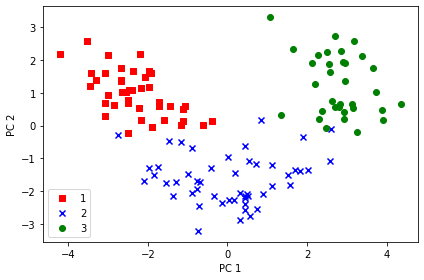

In [26]:
#124x2次元の行列として格納された変換後のwine訓練データセットを2次元の散布図としてプロット
colors=['r', 'b','g']
markers=['s', 'x', 'o']

#クラスラベル，点の色，点の種類の組み合わせからなるリストを生成してプロット
for l, c,m in zip(np.unique(y_train),colors,markers):
        plt.scatter(x_train_pca[y_train==l, 0],  x_train_pca[y_train==l, 1], c=c, label=l,  marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [29]:
#PCAクラスを使い，ロジスティック回帰によって変換後のデータ点を分類する
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,resolution=0.02):
    #マーカーとカラーマップの準備
    markers=('s', 'x', 'o', '^', 'v')
    colors=('red', 'blue', 'lightgreen', 'gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    #決定領域のプロット
    x1_min,  x1_max=X[:,0].min() - 1,  X[:,0].max()  + 1
    x2_min,  x2_max=X[:,1].min() - 1,  X[:,1].max()  + 1
    
    #グリッドポイントの生成
    xx1, xx2=np.meshgrid(np.arange(x1_min, x1_max, resolution),
                        np.arange(x2_min, x2_max, resolution))
    
    #各特徴量を１次元配列に変換して予測を実行
    Z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    
    #予測結果を元のグリッドポイントのデータサイズに変換
    Z=Z.reshape(xx1.shape)
    
    #グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2,  Z, alpha=0.4, cmap=cmap)
    
    #軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())
    
    #クラスごとにデータ点をプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.6, color=cmap(idx),
                   edgecolor='black',marker=markers[idx], label=cl)

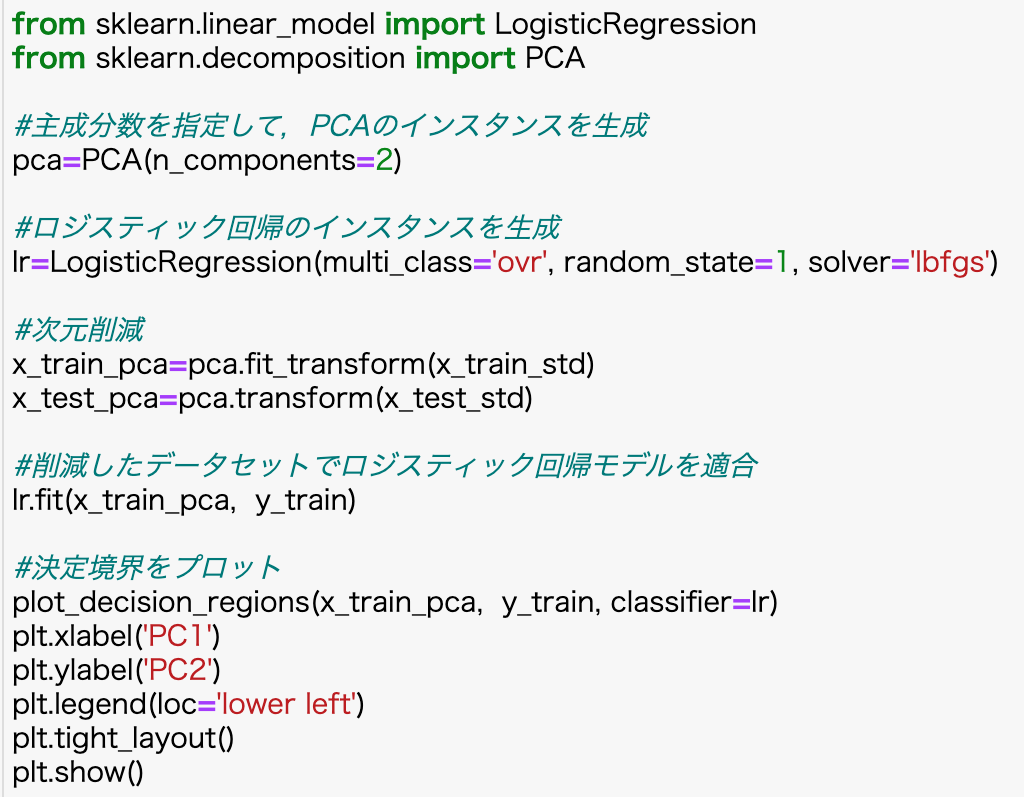

<ipython-input-29-0ba699ca4328>:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.6, color=cmap(idx),


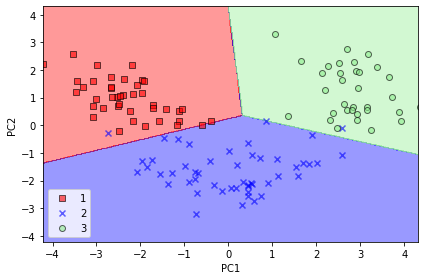

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#主成分数を指定して，PCAのインスタンスを生成
pca=PCA(n_components=2)

#ロジスティック回帰のインスタンスを生成
lr=LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')

#次元削減
x_train_pca=pca.fit_transform(x_train_std)
x_test_pca=pca.transform(x_test_std)

#削減したデータセットでロジスティック回帰モデルを適合
lr.fit(x_train_pca,  y_train)

#決定境界をプロット
plot_decision_regions(x_train_pca,  y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

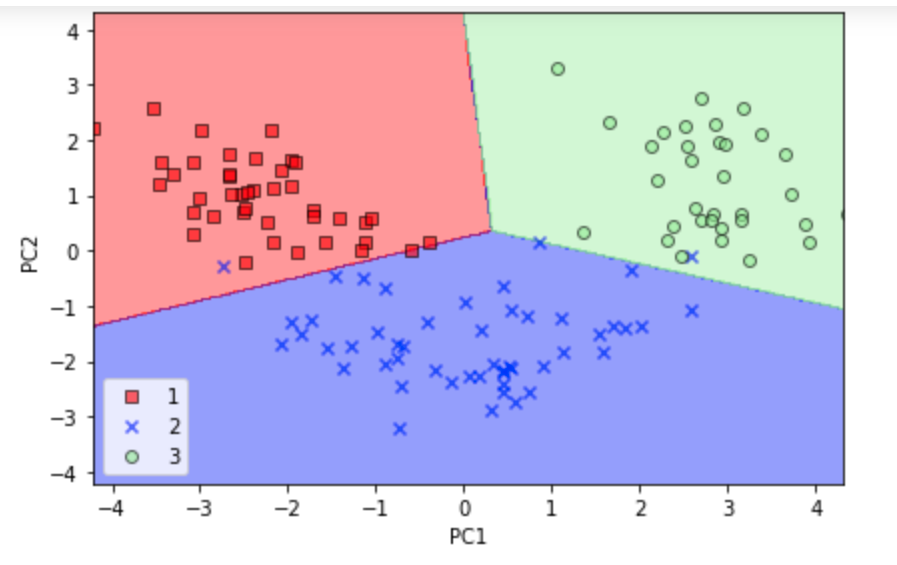

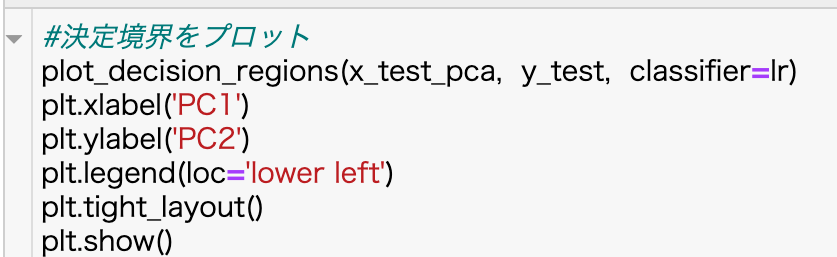

<ipython-input-29-0ba699ca4328>:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.6, color=cmap(idx),


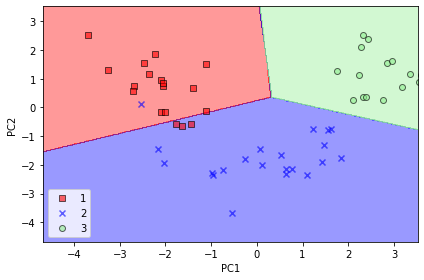

In [32]:
#決定境界をプロット
plot_decision_regions(x_test_pca,  y_test,  classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

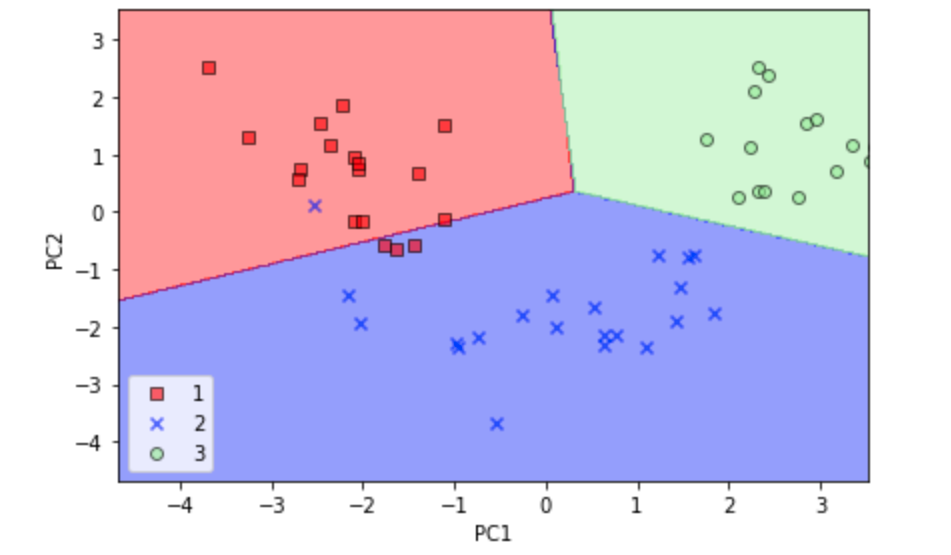

In [33]:
#次元削減を実行する代わりに全ての主成分がソートされた状態で返されるようにするため
pca=PCA(n_components=None)
x_train_pca=pca.fit_transform(x_train_std)

#分散説明率を計算
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])